# AnimalClassification
by Blaha (s1910454002), Gratzl (s1910454009), Piringer (s1910454024)

We decided to train a model to classify four different animal classes (spider, elefant, sheep and chicken).

### Imports & Setup

In [315]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
from tensorflow.keras import layers, regularizers
import random
import matplotlib.image as mpimg 
import matplotlib.pyplot as plt
import itertools

In [316]:
rootDir = './animals-dataset'
trainingDir = rootDir + '/training'
testDir = rootDir + '/test'

In [317]:
seed = 512
validation_split = 0.2
interpolation = "bilinear"
batch_size = 16
img_height = 256
img_width = 256

### Creating tensorflow datasets from directory
#### Training data

In [318]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="training",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation,
    color_mode="rgb"
)

Found 400 files belonging to 4 classes.
Using 320 files for training.


#### Validation data

In [319]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    trainingDir,
    validation_split=validation_split,
    subset="validation",
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation,
    color_mode="rgb"
)

Found 400 files belonging to 4 classes.
Using 80 files for validation.


#### Test data

In [320]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    testDir,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    interpolation=interpolation,
    color_mode="rgb"
)

Found 80 files belonging to 4 classes.


#### Print classification classes

In [321]:
class_names = train_ds.class_names
print(class_names)

['chicken', 'elefant', 'sheep', 'spider']


### Show some of the data

#### Training dataset

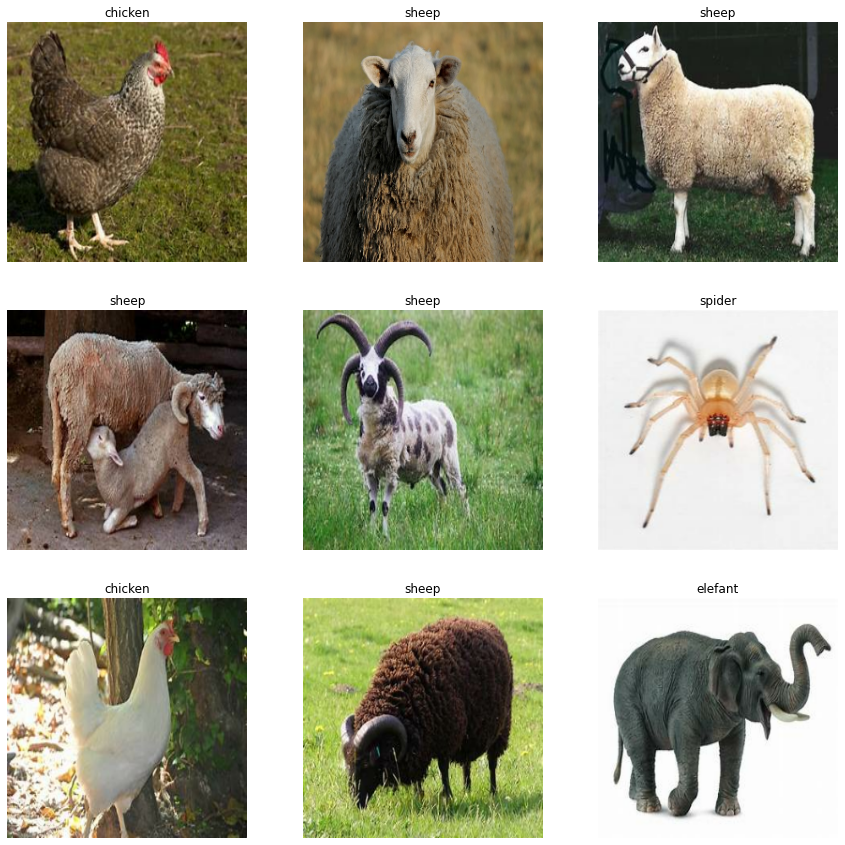

In [322]:
plt.figure(figsize=(15, 15))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

#### Test dataset

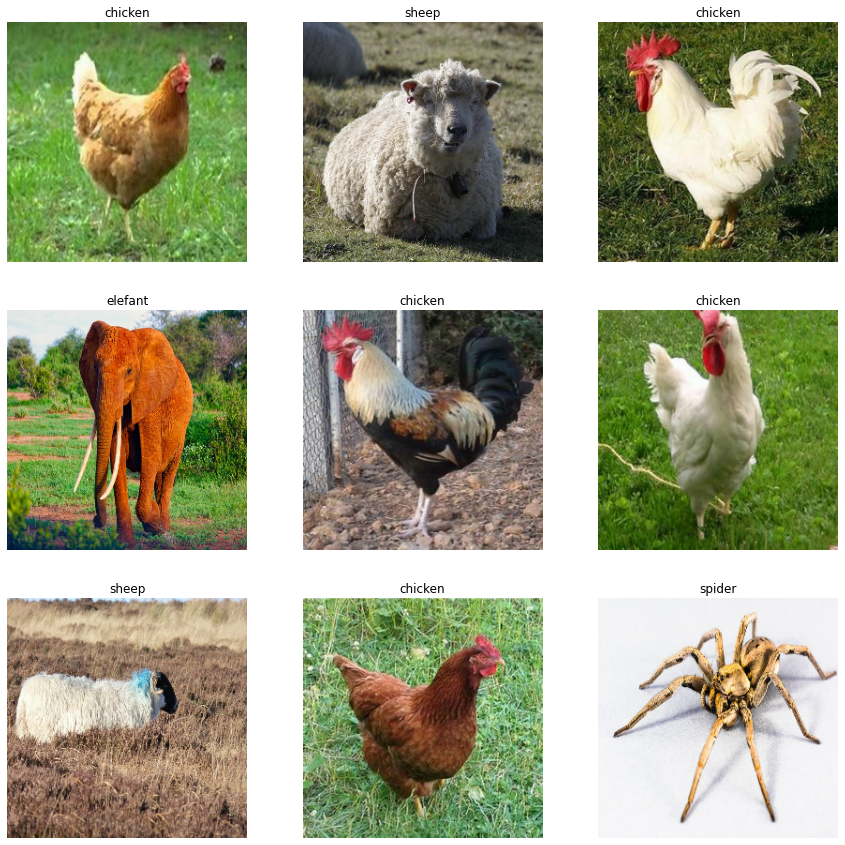

In [323]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Print data format and prepare cache

In [324]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

(16, 256, 256, 3)
(16,)


### Create Tensorflow model

#### Define the layers of the models

We experimented a lot with the types and order of the layers following with many different tutorials. We experienced the problem of overfitting and tried to counter it with the use of some `Dropout` layers and L2 kernel regularizers.

In [325]:
num_classes = len(class_names)
print(num_classes)
    
# model = tf.keras.Sequential([
#     layers.experimental.preprocessing.Rescaling(1./255),
#     layers.Conv2D(16, 2, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 2, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 2, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Flatten(),
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     layers.Dropout(0.5),
#     #layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     #layers.Dropout(0.5),
#     #layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
#     #layers.Dropout(0.5),
#     layers.Dense(num_classes)
# ])
    
model = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.experimental.preprocessing.RandomRotation(factor=0.2),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    layers.Dense(num_classes)
])

4


#### Compile the model

In [326]:
model.compile(
  optimizer=tf.optimizers.Adam(learning_rate=0.001),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

model.summary()

Model: "sequential_43"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_35 (Rescaling)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation_20 (RandomRo (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_96 (Conv2D)           (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 128, 128, 32)      4640      
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 64, 64, 64)      

#### Train the model

In [327]:
history = model.fit(
    train_ds,
    #steps_per_epoch=100,
    validation_data=val_ds,
    epochs=25
)

Epoch 1/25
20/20 [==============================] - 9s 451ms/step - loss: 2.7488 - accuracy: 0.2594 - val_loss: 2.3208 - val_accuracy: 0.3375
Epoch 2/25
20/20 [==============================] - 8s 422ms/step - loss: 2.1529 - accuracy: 0.3438 - val_loss: 2.0583 - val_accuracy: 0.3875
Epoch 3/25
20/20 [==============================] - 8s 424ms/step - loss: 1.9194 - accuracy: 0.3375 - val_loss: 1.8486 - val_accuracy: 0.3000
Epoch 4/25
20/20 [==============================] - 9s 438ms/step - loss: 1.7414 - accuracy: 0.4437 - val_loss: 1.7104 - val_accuracy: 0.4625
Epoch 5/25
20/20 [==============================] - 9s 426ms/step - loss: 1.6623 - accuracy: 0.4281 - val_loss: 1.5423 - val_accuracy: 0.5375
Epoch 6/25
20/20 [==============================] - 8s 418ms/step - loss: 1.5352 - accuracy: 0.5188 - val_loss: 1.4675 - val_accuracy: 0.6375
Epoch 7/25
20/20 [==============================] - 9s 433ms/step - loss: 1.3797 - accuracy: 0.5906 - val_loss: 1.4243 - val_accuracy: 0.6125
Epoch 

#### Plot model accuracy (training and validation)

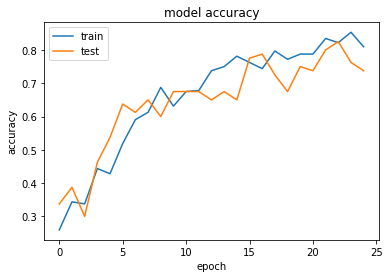

In [328]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Plot the model loss (training and validation)

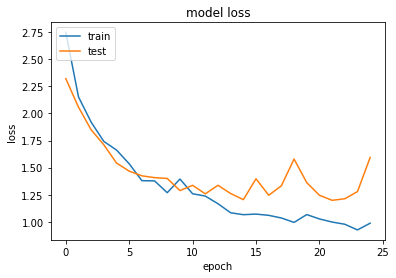

In [329]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

The plot shows that the validation loss starts to fluctuate at epoch 15.

#### Evaluate the test data

In [330]:
test_loss, test_acc = model.evaluate(test_ds, verbose=1)

5/5 [==============================] - 0s 79ms/step - loss: 1.7424 - accuracy: 0.7125


In [331]:
print('Test accuracy: ' +  str(test_acc) + " Loss: " + str(test_loss))

Test accuracy: 0.7124999761581421 Loss: 1.7424236536026


#### Create predictions for the test data

In [332]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
predictions = probability_model.predict(test_ds)

In [333]:
predictions[0]

array([7.2790484e-04, 7.6795746e-05, 5.6868892e-05, 9.9913836e-01],
      dtype=float32)

In [334]:
np.argmax(predictions[0])

3

#### Plot the results (image with predicted label)

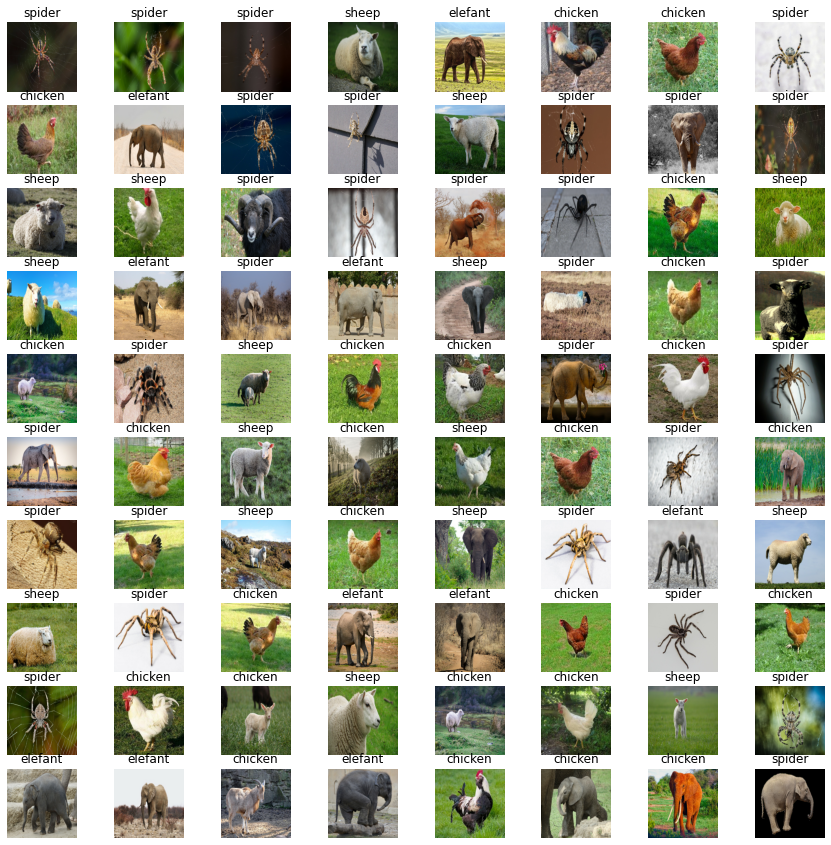

In [335]:
plt.figure(figsize=(15, 15))
test_images = []

for images, labels in test_ds:
    test_images.extend(images)

for i,img in enumerate(test_images):
    ax = plt.subplot(10, 8, i + 1)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

### Show confusion matrix

create two lists with the labels and predictions

In [336]:
prediction_counter = 0
l = []
p = []
for images, labels in test_ds:
    for i in range(len(labels)):
        l.append(labels[i].numpy())
        p.append(np.argmax(predictions[prediction_counter]))
        prediction_counter += 1

In [337]:
cm = tf.math.confusion_matrix(l, p)
cm = cm / len(l) # for normalization

The code for the plot of the confusion matrix is copied from [here](https://towardsdatascience.com/exploring-confusion-matrix-evolution-on-tensorboard-e66b39f4ac12). We modfied it to fit the tensorflow dataset api.

In [338]:
# https://docs.python.org/3/library/itertools.html#module-itertools
# https://www.tensorflow.org/api_docs/python/tf/math/confusion_matrix
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Use white text if squares are dark; otherwise black.
    threshold = np.max(cm) / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j].numpy(), horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return figure

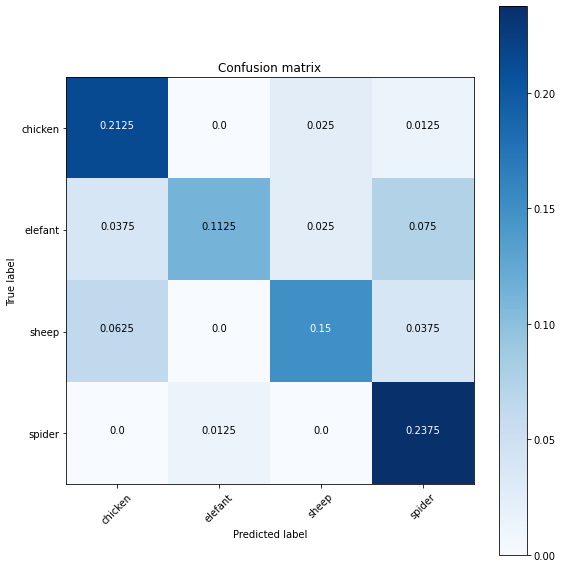

In [339]:
plot_confusion_matrix(cm, class_names)